## Deeper analysis of Rijden de Treinen data

(using the .venv from lab, so no lock file)

### 1. Download data

The following were downloaded from https://www.rijdendetreinen.nl/en/open-data into "data" folder:
- inter-station distances in 2022
- railway stations in 2023 (dutch and international)
- train disruptions between 2011 and 2023
- train services between 2019 and 2025 (downloaded 2019-2024, to simplify as 2025 not yet in one complete file)

(services were downloaded using wget)

### 2. Put stations data into stations table in DuckDB. 

In [1]:
import duckdb

db = duckdb.connect("data/duckdb_trains.db")
db

In [2]:
db.sql("""
CREATE TABLE IF NOT EXISTS stations AS
FROM "data/stations-2023-09.csv"
""")

In [35]:
# db.sql("SHOW ALL TABLES")

### 3. Create tables `distances` and `distances_long`
This changes rarely, so it can be treated as an almost constant file.

In [4]:
! head -n 9 data/tariff-distances-2022-01.csv | cut -d, -f1-9

Station,AC,AH,AHP,AHPR,AHZ,AKL,AKM,ALM
AC,XXX,82,83,85,90,71,188,32
AH,82,XXX,1,3,8,77,153,98
AHP,83,1,XXX,2,9,78,152,99
AHPR,85,3,2,XXX,11,80,150,101
AHZ,90,8,9,11,XXX,69,161,106
AKL,71,77,78,80,69,XXX,211,96
AKM,188,153,152,150,161,211,XXX,158
ALM,32,98,99,101,106,96,158,XXX


In [5]:
db.sql("""
CREATE TABLE IF NOT EXISTS distances AS
    FROM read_csv(
        "data/tariff-distances-2022-01.csv",
        nullstr = 'XXX'
    );
""")

In [6]:
db.sql("""
FROM (DESCRIBE distances)
LIMIT 5;
""")

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ Station     │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ AC          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AH          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AHP         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AHPR        │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
└─────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

In [7]:
db.sql("""
SELECT #1, #2, #3, #4, #5, #6, #7, #8, #9
FROM distances
LIMIT 8;
""")

┌─────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ Station │  AC   │  AH   │  AHP  │ AHPR  │  AHZ  │  AKL  │  AKM  │  ALM  │
│ varchar │ int64 │ int64 │ int64 │ int64 │ int64 │ int64 │ int64 │ int64 │
├─────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ AC      │  NULL │    82 │    83 │    85 │    90 │    71 │   188 │    32 │
│ AH      │    82 │  NULL │     1 │     3 │     8 │    77 │   153 │    98 │
│ AHP     │    83 │     1 │  NULL │     2 │     9 │    78 │   152 │    99 │
│ AHPR    │    85 │     3 │     2 │  NULL │    11 │    80 │   150 │   101 │
│ AHZ     │    90 │     8 │     9 │    11 │  NULL │    69 │   161 │   106 │
│ AKL     │    71 │    77 │    78 │    80 │    69 │  NULL │   211 │    96 │
│ AKM     │   188 │   153 │   152 │   150 │   161 │   211 │  NULL │   158 │
│ ALM     │    32 │    98 │    99 │   101 │   106 │    96 │   158 │  NULL │
└─────────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┘

In [8]:
db.sql("""
CREATE TABLE IF NOT EXISTS distances_long AS
    UNPIVOT distances
    ON COLUMNS (* EXCLUDE station)
    INTO NAME other_station VALUE distance;
""")

In [9]:
db.sql("""
SELECT station, other_station, distance
FROM distances_long
LIMIT 3;
""")

┌─────────┬───────────────┬──────────┐
│ Station │ other_station │ distance │
│ varchar │    varchar    │  int64   │
├─────────┼───────────────┼──────────┤
│ AC      │ AH            │       82 │
│ AC      │ AHP           │       83 │
│ AC      │ AHPR          │       85 │
└─────────┴───────────────┴──────────┘

In [10]:
db.sql("""
SELECT
    s1.name_long AS station1,
    s2.name_long AS station2,
    distances_long.distance
FROM distances_long
JOIN stations s1 ON distances_long.station = s1.code
JOIN stations s2 ON distances_long.other_station = s2.code
WHERE s1.country = 'NL'
  AND s2.country = 'NL'
  AND station < other_station
ORDER BY distance DESC
LIMIT 3;
""")

┌──────────────────┬────────────────────┬──────────┐
│     station1     │      station2      │ distance │
│     varchar      │      varchar       │  int64   │
├──────────────────┼────────────────────┼──────────┤
│ Eemshaven        │ Vlissingen         │      426 │
│ Bad Nieuweschans │ Vlissingen         │      425 │
│ Eemshaven        │ Vlissingen Souburg │      425 │
└──────────────────┴────────────────────┴──────────┘

In [36]:
# db.sql("SHOW ALL TABLES")

### 4. Postgres database for disruptions table
This data is expected to change regularly, so it's treated a typical OLTP table.

In [12]:
# install and import extension
db.sql("""INSTALL postgres; LOAD postgres;""")

# NEVER write password like this explicitly in real code!
conn_string = "host=localhost user=postgres password=postgres dbname=postgres"

# note that we create the alias for this Postgres database here
# this also needs to be in single quotes
db.sql(f"""
ATTACH IF NOT EXISTS '{conn_string}' AS postgres_db (TYPE postgres);
""")

In [13]:
db.sql("DESCRIBE 'data/disruptions-2011.csv'")

┌──────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│     column_name      │ column_type │  null   │   key   │ default │  extra  │
│       varchar        │   varchar   │ varchar │ varchar │ varchar │ varchar │
├──────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ rdt_id               │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ ns_lines             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_lines            │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_lines_id         │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_station_names    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_station_codes    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ cause_nl             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ cause_en             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ statistical_cause_nl │ VARCHAR     │ YES     │ NUL

In [14]:
import glob

years = range(2011, 2024)

case_conditions = "\n    ".join([f"WHEN filename LIKE '%{y}%' THEN {y}" for y in years])

csv_paths = sorted(glob.glob("data/disruptions-*.csv"))
file_list_sql = ",\n".join(f"'{file}'" for file in csv_paths)

query = f"""
CREATE TABLE IF NOT EXISTS postgres_db.disruptions AS
SELECT*,
  CASE
    {case_conditions}
  END AS year,
FROM read_csv(
  [{file_list_sql}],
  header = TRUE,
  union_by_name = TRUE,
  filename = TRUE
);
"""
print(query)  # optional preview


CREATE TABLE IF NOT EXISTS postgres_db.disruptions AS
SELECT*,
  CASE
    WHEN filename LIKE '%2011%' THEN 2011
    WHEN filename LIKE '%2012%' THEN 2012
    WHEN filename LIKE '%2013%' THEN 2013
    WHEN filename LIKE '%2014%' THEN 2014
    WHEN filename LIKE '%2015%' THEN 2015
    WHEN filename LIKE '%2016%' THEN 2016
    WHEN filename LIKE '%2017%' THEN 2017
    WHEN filename LIKE '%2018%' THEN 2018
    WHEN filename LIKE '%2019%' THEN 2019
    WHEN filename LIKE '%2020%' THEN 2020
    WHEN filename LIKE '%2021%' THEN 2021
    WHEN filename LIKE '%2022%' THEN 2022
    WHEN filename LIKE '%2023%' THEN 2023
  END AS year,
FROM read_csv(
  ['data/disruptions-2011.csv',
'data/disruptions-2012.csv',
'data/disruptions-2013.csv',
'data/disruptions-2014.csv',
'data/disruptions-2015.csv',
'data/disruptions-2016.csv',
'data/disruptions-2017.csv',
'data/disruptions-2018.csv',
'data/disruptions-2019.csv',
'data/disruptions-2020.csv',
'data/disruptions-2021.csv',
'data/disruptions-2022.csv',
'd

In [15]:
db.sql(query)

In [37]:
# db.sql("SHOW ALL TABLES")

In [17]:
db.sql("FROM postgres_db.disruptions WHERE year == 2011 LIMIT 5").show()

┌────────┬──────────────────────────────────┬────────────────────────────────────┬──────────────┬───────────────────┬───────────────────┬────────────────────────────┬───────────────────────┬────────────────────────────┬───────────────────────┬───────────────┬─────────────────────┬─────────────────────┬──────────────────┬───────┐
│ rdt_id │             ns_lines             │             rdt_lines              │ rdt_lines_id │ rdt_station_names │ rdt_station_codes │          cause_nl          │       cause_en        │    statistical_cause_nl    │ statistical_cause_en  │  cause_group  │     start_time      │      end_time       │ duration_minutes │ year  │
│ int64  │             varchar              │              varchar               │   varchar    │      varchar      │      varchar      │          varchar           │        varchar        │          varchar           │        varchar        │    varchar    │      timestamp      │      timestamp      │      int64       │ int32 │
├──────

In [18]:
db.sql("ALTER TABLE postgres_db.disruptions DROP COLUMN IF EXISTS filename")

### 5. `services` table from a single parquet file
"Transform train services CSV files into a single Parquet file. Make table services from it. We treat this as a big data batch input, created rarely but regularly for analytics purposes."

In [19]:
db.sql(
    "COPY (FROM 'data/services-20*.csv') TO 'data/services.parquet' (FORMAT PARQUET, CODEC ZSTD);"
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [20]:
db.sql("""
CREATE TABLE IF NOT EXISTS services AS
FROM 'data/services.parquet'
""")

In [38]:
# db.sql("SHOW ALL TABLES")

In [22]:
# check if all years got merged
db.sql("""
SELECT
  EXTRACT(YEAR FROM CAST("Service:Date" AS DATE)) AS year,
  COUNT(*) AS num_rows
FROM services
GROUP BY year
ORDER BY year;
""")

┌───────┬──────────┐
│ year  │ num_rows │
│ int64 │  int64   │
├───────┼──────────┤
│  2019 │ 20773804 │
│  2020 │ 22235137 │
│  2021 │ 21818011 │
│  2022 │ 22025754 │
│  2023 │ 21239393 │
│  2024 │ 21857914 │
└───────┴──────────┘

### 6. "In all following questions, use tables services, distances_long, disruptions and stations as necessary. Remember that each row represents single ride between stations, while the whole end-to-end train service has the same value in Service:RDT-ID column. Note that starting station for a service has NULL value in Stop:Arrival time column, while the end station has NULL value in Stop:Departure time column."

### 7. Queries to answer various questions

In [23]:
db.sql("DESCRIBE services")

┌──────────────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│         column_name          │ column_type │  null   │   key   │ default │  extra  │
│           varchar            │   varchar   │ varchar │ varchar │ varchar │ varchar │
├──────────────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ Service:RDT-ID               │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Date                 │ DATE        │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Type                 │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Company              │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Train number         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Completely cancelled │ BOOLEAN     │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Partly cancelled     │ BOOLEAN     │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Maximum delay        │ BIGINT    

In [24]:
# How many trains departed from Amsterdam Central station overall?
db.sql("""
SELECT COUNT(*) AS num_departures
FROM services
WHERE "Stop:Station name" = 'Amsterdam Centraal'
  AND "Stop:Departure time" IS NOT NULL
  AND "Stop:Departure cancelled" IS NOT TRUE
  AND "Service:Completely cancelled" IS NOT TRUE
""")

┌────────────────┐
│ num_departures │
│     int64      │
├────────────────┤
│        1544223 │
└────────────────┘

In [25]:
# Calculate the average arrival delay of different service types (Service:Type). Order results descending by average delay.
db.sql("""
SELECT
  "Service:Type" AS service_type,
  AVG("Stop:Arrival delay") AS avg_arrival_delay
FROM services
WHERE "Stop:Arrival delay" IS NOT NULL
  AND "Stop:Arrival cancelled" IS NOT TRUE
  AND "Service:Completely cancelled" IS NOT TRUE
GROUP BY "Service:Type"
ORDER BY avg_arrival_delay DESC
""")

┌──────────────────────┬────────────────────┐
│     service_type     │ avg_arrival_delay  │
│       varchar        │       double       │
├──────────────────────┼────────────────────┤
│ Alpen Express        │ 27.826625386996906 │
│ Krokus Express       │ 18.304347826086957 │
│ European Sleeper     │ 12.453668861712135 │
│ Nightjet             │  9.440268908401517 │
│ Eurostar             │ 7.1566729792845445 │
│ Thalys               │  5.704365823405544 │
│ ICE International    │  5.644048933081126 │
│ Nachttrein           │ 4.5620731217356365 │
│ Int. Trein           │ 4.5009871668311945 │
│ Dinner Train         │              3.792 │
│      ·               │                 ·  │
│      ·               │                 ·  │
│      ·               │                 ·  │
│ Tram ipv trein       │                0.0 │
│ Niet instappen       │                0.0 │
│ Metro i.p.v. trein   │                0.0 │
│ stoptrein            │                0.0 │
│ Snelbus i.p.v. trein │          

In [26]:
# What was the most common disruption cause in different years?
db.sql("""
SELECT
  year,
  MODE("cause_en") AS most_common_cause
FROM postgres_db.disruptions
GROUP BY year
""")

┌───────┬───────────────────┐
│ year  │ most_common_cause │
│ int32 │      varchar      │
├───────┼───────────────────┤
│  2016 │ broken down train │
│  2011 │ broken down train │
│  2015 │ broken down train │
│  2023 │ broken down train │
│  2012 │ points failure    │
│  2017 │ broken down train │
│  2022 │ broken down train │
│  2020 │ broken down train │
│  2021 │ broken down train │
│  2014 │ broken down train │
│  2018 │ broken down train │
│  2013 │ points failure    │
│  2019 │ broken down train │
├───────┴───────────────────┤
│ 13 rows         2 columns │
└───────────────────────────┘

In [34]:
# How many trains started their overall service in any Amsterdam station?
db.sql("""
SELECT COUNT(*) 
FROM services
WHERE "Stop:Departure time" IS NOT NULL AND
    "Stop:Departure Cancelled" IS NOT TRUE AND
    "Stop:Arrival Time" IS NULL AND
    "Service:Completely cancelled" IS NOT TRUE AND
    "Stop:Station name" LIKE '%Amsterdam%'
""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│       998792 │
└──────────────┘

In [ ]:
# What fraction of services was run to final destinations outside the Netherlands?
db.sql("""
SELECT
  SUM(CASE WHEN s.country <> 'NL' THEN 1 ELSE 0 END) AS services_outside_nl,
  COUNT(*) AS services_with_known_country,
  SUM(CASE WHEN s.country <> 'NL' THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS fraction_outside_nl
FROM (
  SELECT DISTINCT "Service:RDT-ID" AS service_id, "Stop:Station code" AS station_code
  FROM services
  WHERE "Stop:Departure time" IS NULL
    AND "Service:Completely cancelled" IS NOT TRUE
) finals
LEFT JOIN stations s ON s.code = finals.station_code
WHERE s.country IS NOT NULL;       
""")

┌─────────────────────┬─────────────────────────────┬─────────────────────┐
│ services_outside_nl │ services_with_known_country │ fraction_outside_nl │
│       int128        │            int64            │       double        │
├─────────────────────┼─────────────────────────────┼─────────────────────┤
│              507901 │                    13545761 │ 0.03749519868245128 │
└─────────────────────┴─────────────────────────────┴─────────────────────┘

In [43]:
# What is the largest distance between stations in the Netherlands (code NL)?
db.sql("""
SELECT
    s1.name_long AS station1,
    s2.name_long AS station2,
    distances_long.distance as longest_distance
FROM distances_long
JOIN stations s1 ON distances_long.station = s1.code
JOIN stations s2 ON distances_long.other_station = s2.code
WHERE s1.country = 'NL'
  AND s2.country = 'NL'
  AND station < other_station
ORDER BY distance DESC
LIMIT 1;
""")

┌───────────┬────────────┬──────────────────┐
│ station1  │  station2  │ longest_distance │
│  varchar  │  varchar   │      int64       │
├───────────┼────────────┼──────────────────┤
│ Eemshaven │ Vlissingen │              426 │
└───────────┴────────────┴──────────────────┘

In [58]:
# Compare the average arrival delay between different train operators (Service:Company) on a bar plot. Sort them appropriately.
avg_delays_by_operators = db.sql("""
SELECT "Service:Company" as operator,
       AVG("Stop:Arrival delay") AS avg_delay
FROM services
WHERE "Stop:Arrival delay" IS NOT NULL
GROUP BY "Service:Company"
ORDER BY avg_delay DESC
""").df()

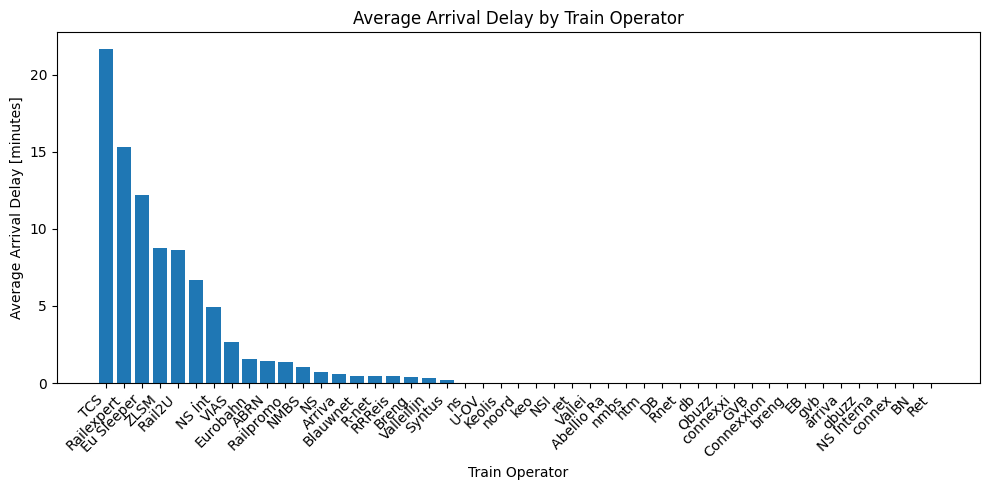

In [68]:
import matplotlib.pyplot as plt

# make sure data is sorted
avg_delays_by_operators = avg_delays_by_operators.sort_values(
    "avg_delay", ascending=False
)

plt.figure(figsize=(10, 5))
plt.bar(avg_delays_by_operators["operator"], avg_delays_by_operators["avg_delay"])
plt.title("Average Arrival Delay by Train Operator")
plt.xlabel("Train Operator")
plt.ylabel("Average Arrival Delay [minutes]")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [62]:
# How many services were disrupted in different years? Make a line plot.
services_disrupted_by_year = db.sql("""
SELECT
  year,
  COUNT(*) AS num_disruptions
FROM postgres_db.disruptions
GROUP BY year
""").df()

# not sorted bcs it threw errors before

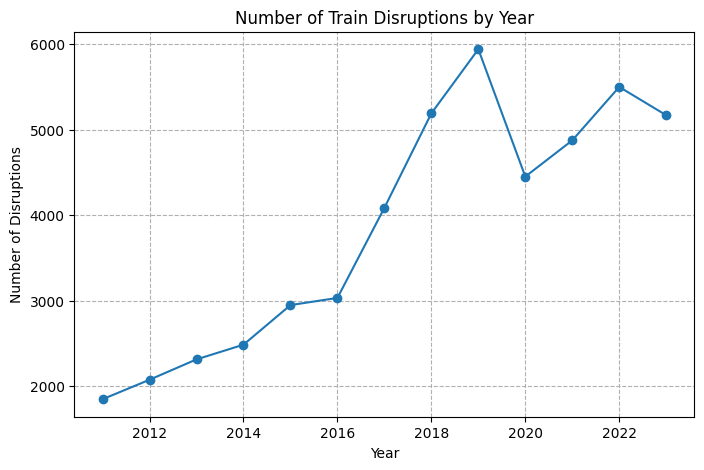

In [72]:
services_disrupted_by_year = services_disrupted_by_year.sort_values("year")

plt.figure(figsize=(8, 5))
plt.plot(
    services_disrupted_by_year["year"],
    services_disrupted_by_year["num_disruptions"],
    marker="o",
    linestyle="-",
)
plt.title("Number of Train Disruptions by Year")
plt.xlabel("Year")
plt.ylabel("Number of Disruptions")
plt.grid(linestyle="--")
plt.show()

In [71]:
# What fraction of all services were cancelled (Service:Completely cancelled) in different years? Make a line plot.
fraction_services_cancelled_by_year = db.sql("""
SELECT
    YEAR("Service:Date") AS year,
    SUM(
        CASE 
            WHEN "Service:Completely cancelled" IS TRUE THEN 1 ELSE 0 
        END) 
    * 1.0 / COUNT(*) AS fraction
FROM services
GROUP BY year
ORDER BY year ASC
""").df()

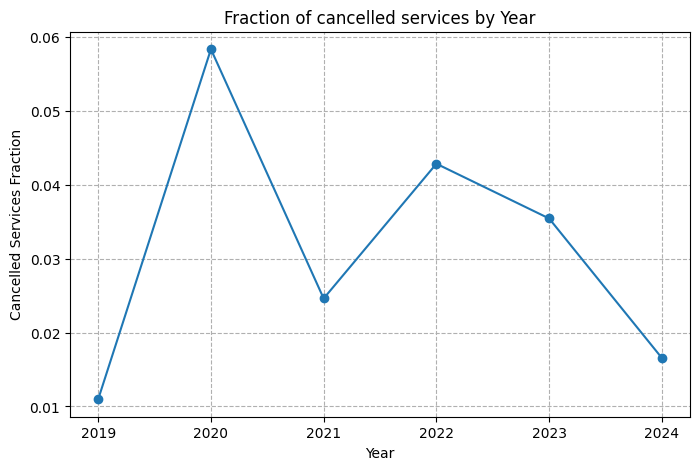

In [73]:
plt.figure(figsize=(8, 5))
plt.plot(
    fraction_services_cancelled_by_year["year"],
    fraction_services_cancelled_by_year["fraction"],
    marker="o",
    linestyle="-",
)
plt.title("Fraction of cancelled services by Year")
plt.xlabel("Year")
plt.ylabel("Cancelled Services Fraction")
plt.grid(linestyle="--")
plt.show()